In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import jupyter_black

jupyter_black.load()

In [2]:
import os

print(os.getcwd())

/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Notebooks


In [3]:
df_customer_Churn = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/Daily_Churned_customers_JET.csv"
)

df_input_accounts = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/input_accounts_21_10_2022.csv"
)

df_tweets = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/tweets-2022-10-21_justeattakeaway.csv"
)

In [4]:
df_tweets = pd.merge(
    left=df_tweets,
    right=df_input_accounts,
    left_on="user_id",
    right_on="user_id",
    how="left",
)
df_input_accounts = None

## Only get english Tweets

In [5]:
# delta chrun
df_customer_Churn["d_churn"] = (
    df_customer_Churn["Churned customers"].shift(1)
    - df_customer_Churn["Churned customers"]
)

# Part 2. Data analysis of the platform’s Twitter data

## data Preprocessing

##### 1. Remove all non-character signs and stop words (Stop words are a set of commonly used words in a language that do not have any meaning. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.):

In [6]:
import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [7]:
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import CountVectorizer
from termcolor import colored
import math

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import gensim

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize


import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
def show_vocabulary(vectorizer, word_size=15, words_per_line=10):
    words = vectorizer.get_feature_names()

    print(f"Vocabulary size: {len(words)} words")

    word_format = f"<{word_size}"
    for l in np.array_split(words, math.ceil(len(words) / words_per_line)):
        print("".join([f"{x:{word_format}}" for x in l]))


def show_bow(vectorizer, bow, word_size=15, words_per_line=8):
    words = vectorizer.get_feature_names()

    word_format = f"<{word_size}"
    for l in np.array_split(
        list(zip(words, bow)), math.ceil(len(words) / words_per_line)
    ):
        print(
            " | ".join(
                [
                    colored(f"{w:{word_format}}:{n:>2}", "grey")
                    if int(n) == 0
                    else colored(
                        f"{w:{word_format}}:{n:>2}",
                        on_color="on_yellow",
                        attrs=["bold"],
                    )
                    for w, n in l
                ]
            )
        )


def show_bow_float(vectorizer, bow, word_size=15, words_per_line=6):
    words = vectorizer.get_feature_names()

    word_format = f"<{word_size}"
    for l in np.array_split(
        list(zip(words, bow)), math.ceil(len(words) / words_per_line)
    ):
        print(
            " | ".join(
                [
                    colored(f"{w:word_format}:{float(n):>0.2f}", "grey")
                    if float(n) == 0
                    else colored(
                        f"{w:word_format}:{float(n):>0.2f}",
                        on_color="on_yellow",
                        attrs=["bold"],
                    )
                    for w, n in l
                ]
            )
        )

In [9]:
additional = [
    "rt",
    "rts",
    "retweet",
    "please",
    "ha",
]  # we'll store additional stopwords here
swords = set().union(stopwords.words("english"), additional)

# replace all signs and stopwords in tweets and tokenize tweets (tokenization means splitting up a larger body of text into pieces such as words, keywords, phrases, symbols and other elements called tokens; in our case we can split the tweets into words)
df_tweets.drop_duplicates(subset="text", inplace=True)
df_tweets["text"] = df_tweets["text"].str.lower()

df_tweets["processed_text"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
    .apply(lambda x: [i for i in x.split() if not i in swords])
)

df_tweets["processed_text_"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
)

/tmp/ipykernel_13710/3705902228.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]
/tmp/ipykernel_13710/3705902228.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]


In [10]:
wnl = WordNetLemmatizer()


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        regex_num_ponctuation = "(\d+)|([^\w\s])"
        regex_little_words = r"(\b\w{1,2}\b)"
        regex_smiley = "(@[a-z0-9]+)\w+"
        regex_signs = "(http\S+)"
        regex_tweet_spec = "([^0-9a-z \t])"
        regex_https = " +"
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if not re.search(regex_num_ponctuation, t)
            and not re.search(regex_smiley, t)
            and not re.search(regex_signs, t)
            and not re.search(regex_tweet_spec, t)
            and not re.search(regex_little_words, t)
            and not re.search(regex_https, t)
        ]

In [11]:
df_tweets_jet = df_tweets[df_tweets.lang == "en"]

In [12]:
swords = set().union(stopwords.words("english"), additional)


count = CountVectorizer(
    stop_words=swords,
    tokenizer=LemmaTokenizer(),
    ngram_range=(1, 3),  # will create a vocabulary with 1-gram and 2-grams
    min_df=3,
    max_df=0.9,
    max_features=1000,
)


# count = CountVectorizer(
#     stop_words=swords,
#     tokenizer=LemmaTokenizer(),
#     ngram_range=(1, 3),  # will create a vocabulary with 1-gram and 2-grams
#     min_df=3,
#     max_df=0.9,
#     max_features=2000,
# )

matrix = count.fit_transform(df_tweets_jet.processed_text_)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())
results

/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  warnings.warn(
/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,able drop,able drop order,able follow,able follow request,able resolve,able resolve effectively,account,account additional,account additional detail,...,would mind,would mind dropping,wrong,year,yesterday,yet,yet account,yet account email,yet resolved,yet resolved account
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14755,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())

In [14]:
K = 6

In [15]:
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

In [16]:
lda.print_topics()

[(0,
  '0.016*"take" + 0.016*"eat" + 0.014*"love" + 0.014*"restaurant" + 0.014*"amp" + 0.013*"really" + 0.012*"get" + 0.012*"time" + 0.011*"help" + 0.010*"customer"'),
 (1,
  '0.035*"assist" + 0.033*"account" + 0.033*"address" + 0.033*"email address" + 0.031*"linked" + 0.031*"email" + 0.030*"mobile" + 0.028*"mobile number" + 0.028*"linked account" + 0.026*"email address mobile"'),
 (2,
  '0.027*"email" + 0.027*"detail" + 0.023*"soon" + 0.023*"hand" + 0.018*"lend" + 0.018*"lend hand" + 0.017*"com" + 0.015*"team" + 0.014*"twitter com" + 0.014*"send email"'),
 (3,
  '0.079*"support" + 0.042*"uber" + 0.041*"team" + 0.041*"happy" + 0.040*"help" + 0.040*"eats" + 0.039*"uber eats" + 0.038*"happy help" + 0.038*"assist" + 0.037*"support team"'),
 (4,
  '0.043*"thanks" + 0.031*"take" + 0.022*"reaching" + 0.020*"thanks reaching" + 0.018*"pop" + 0.015*"hey" + 0.014*"like" + 0.014*"pop order number" + 0.014*"pop order" + 0.014*"dm"'),
 (5,
  '0.054*"order" + 0.049*"number" + 0.047*"order number" + 

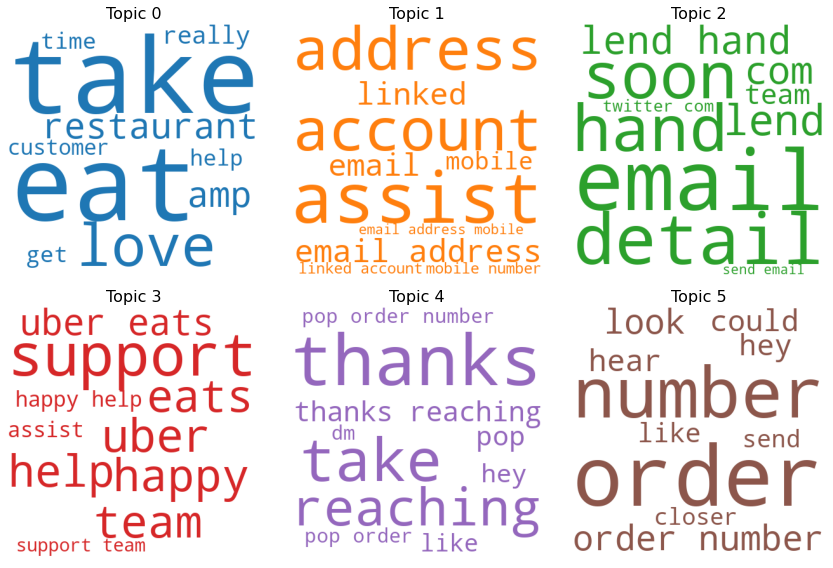

In [17]:
nb_columns = 3
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)

fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(i), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [18]:
# show_vocabulary(count)

In [19]:
lda.print_topics()

[(0,
  '0.016*"take" + 0.016*"eat" + 0.014*"love" + 0.014*"restaurant" + 0.014*"amp" + 0.013*"really" + 0.012*"get" + 0.012*"time" + 0.011*"help" + 0.010*"customer"'),
 (1,
  '0.035*"assist" + 0.033*"account" + 0.033*"address" + 0.033*"email address" + 0.031*"linked" + 0.031*"email" + 0.030*"mobile" + 0.028*"mobile number" + 0.028*"linked account" + 0.026*"email address mobile"'),
 (2,
  '0.027*"email" + 0.027*"detail" + 0.023*"soon" + 0.023*"hand" + 0.018*"lend" + 0.018*"lend hand" + 0.017*"com" + 0.015*"team" + 0.014*"twitter com" + 0.014*"send email"'),
 (3,
  '0.079*"support" + 0.042*"uber" + 0.041*"team" + 0.041*"happy" + 0.040*"help" + 0.040*"eats" + 0.039*"uber eats" + 0.038*"happy help" + 0.038*"assist" + 0.037*"support team"'),
 (4,
  '0.043*"thanks" + 0.031*"take" + 0.022*"reaching" + 0.020*"thanks reaching" + 0.018*"pop" + 0.015*"hey" + 0.014*"like" + 0.014*"pop order number" + 0.014*"pop order" + 0.014*"dm"'),
 (5,
  '0.054*"order" + 0.049*"number" + 0.047*"order number" + 

In [20]:
names = ["Rugby", "Video Games", "Radio", "Internet", "Politics", "Cybersecurity"]

topic_names = {i: v for i, v in enumerate(names)}

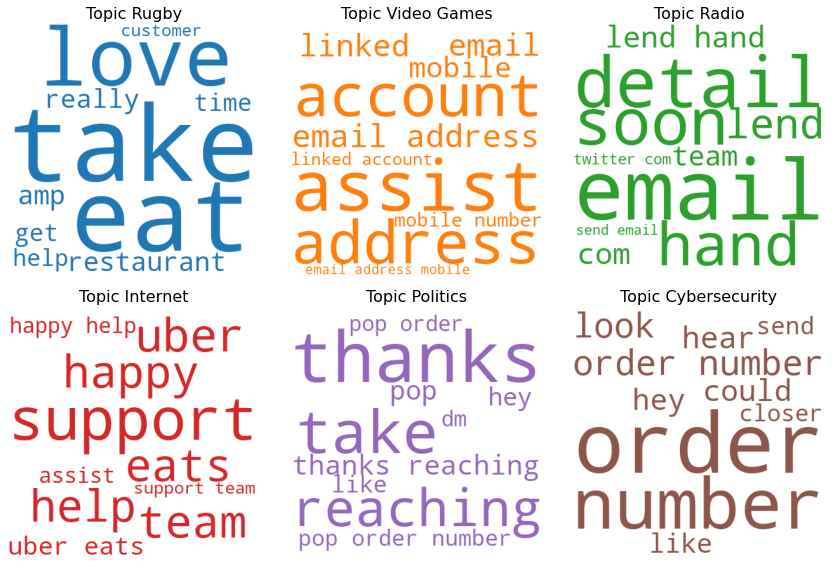

In [21]:
nb_columns = 3
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(names[i]), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Important quesiton: which are the base tweets and which tweets are just tweets that are in reply to the customers 

This is important as we have to figure this out in the preprocessing simply to gain insights with respect which tweets are innovation tweets and which are not.

## Answering 2.1 

In [22]:
# most important topics
lda.print_topics()

[(0,
  '0.016*"take" + 0.016*"eat" + 0.014*"love" + 0.014*"restaurant" + 0.014*"amp" + 0.013*"really" + 0.012*"get" + 0.012*"time" + 0.011*"help" + 0.010*"customer"'),
 (1,
  '0.035*"assist" + 0.033*"account" + 0.033*"address" + 0.033*"email address" + 0.031*"linked" + 0.031*"email" + 0.030*"mobile" + 0.028*"mobile number" + 0.028*"linked account" + 0.026*"email address mobile"'),
 (2,
  '0.027*"email" + 0.027*"detail" + 0.023*"soon" + 0.023*"hand" + 0.018*"lend" + 0.018*"lend hand" + 0.017*"com" + 0.015*"team" + 0.014*"twitter com" + 0.014*"send email"'),
 (3,
  '0.079*"support" + 0.042*"uber" + 0.041*"team" + 0.041*"happy" + 0.040*"help" + 0.040*"eats" + 0.039*"uber eats" + 0.038*"happy help" + 0.038*"assist" + 0.037*"support team"'),
 (4,
  '0.043*"thanks" + 0.031*"take" + 0.022*"reaching" + 0.020*"thanks reaching" + 0.018*"pop" + 0.015*"hey" + 0.014*"like" + 0.014*"pop order number" + 0.014*"pop order" + 0.014*"dm"'),
 (5,
  '0.054*"order" + 0.049*"number" + 0.047*"order number" + 

In [23]:
by_get_document_topics = list(map(lda.get_document_topics, corpus))

by_bracket = lda[corpus]

##### most used words / hashtags / bigrams (trigrams)?

In [24]:
# most fequent words and trigrams

# conver the results into a list of lsits
processed_words = {}
for i, r in results.iterrows():
    processed_words[i] = list(r[r != 0].index)

df_tweets_jet["processed_words_lemma"] = processed_words.values()

df_results = pd.DataFrame(results.sum(), columns=["count_words"]).sort_values(
    by="count_words", ascending=False
)


additiona = {}
counter = 0
for i, r in df_results.iterrows():
    additiona[counter] = len(i.split())

    counter += 1


df_results["length"] = additiona.values()
# load the topics by document!

In [25]:
# most important single words
df_results.count_words.head(5)

# most improtant bigrams
df_results[df_results.length == 2].head(5)

# most important trigrams
df_results[df_results.length == 3].head(5)

,count_words,length
email address mobile,1337,3
address mobile number,1312,3
mobile number linked,1284,3
number linked account,1275,3
support team assist,1157,3


#### words by time of day

In [26]:
# time question
df_tweets_jet["created_at"] = pd.to_datetime(df_tweets_jet.created_at)

df_tweets_jet["year"] = pd.DatetimeIndex(df_tweets_jet.created_at).year
df_tweets_jet["month"] = pd.DatetimeIndex(df_tweets_jet.created_at).month
df_tweets_jet["day"] = pd.DatetimeIndex(df_tweets_jet.created_at).day
df_tweets_jet["hour"] = pd.DatetimeIndex(df_tweets_jet.created_at).hour

In [27]:
df_results

,count_words,length
order,3887,1
help,3561,1
email,3479,1
number,3408,1
assist,3061,1
...,...,...
busy,48,1
situation,48,1
heya,47,1
sorry inconvenience,47,2


In [28]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [29]:
# count number of tweets by company by hour of day/month
df_tweets_jet.groupby(by=["hour", "full_name"]).agg({"tweet_id": "count"})

tweet_id
hour full_name                      
0    Deliveroo                    21
     Just Eat Takeaway.com         3
     Uber Eats                    37
     Uber Eats UK                 21
1    Deliveroo                    14
...                              ...
22   Uber Eats UK                  5
23   Deliveroo                    30
     Just Eat Takeaway.com         3
     Uber Eats                    44
     Uber Eats UK                 14

[126 rows x 1 columns]

In [30]:
df_tweets_jet.groupby(by=["day", "full_name"]).agg({"tweet_id": "count"})

tweet_id
day full_name                      
1   Deliveroo                    78
    Just Eat Takeaway.com        85
    Just Eat UK                 296
    Thuisbezorgd.nl              10
    Uber Eats                   121
...                             ...
31  Just Eat Takeaway.com        36
    Just Eat UK                  41
    Thuisbezorgd.nl               2
    Uber Eats                    47
    Uber Eats UK                 53

[185 rows x 1 columns]

In [31]:
df_tweets_jet.groupby(by=["month", "full_name"]).agg({"tweet_id": "count"})

tweet_id
month full_name                      
1     Just Eat Takeaway.com       172
      Thuisbezorgd.nl              17
      Uber Eats                   153
      Uber Eats UK                225
2     Just Eat Takeaway.com       173
      Thuisbezorgd.nl              15
      Uber Eats                   277
      Uber Eats UK                361
3     Deliveroo                   205
      Just Eat Takeaway.com       233
      Thuisbezorgd.nl               5
      Uber Eats                   244
      Uber Eats UK                524
4     Deliveroo                   400
      Just Eat Takeaway.com       243
      Thuisbezorgd.nl               3
      Uber Eats                   207
      Uber Eats UK                375
5     Deliveroo                   434
      Just Eat Takeaway.com       224
      Thuisbezorgd.nl              13
      Uber Eats                   152
      Uber Eats UK                225
6     Deliveroo                   399
      Just Eat Takeaway.com       224
      Thuisbezorgd.nl              12
      Uber Eats                   267
      Uber Eats UK                272
7     Deliveroo                   437
      Just Eat Takeaway.com       214
      Thuisbezorgd.nl               7
      Uber Eats                   420
      Uber Eats UK                186
8     Deliveroo                   427
      Just Eat Takeaway.com       148
      Just Eat UK                 210
      Thuisbezorgd.nl              17
      Uber Eats                   396
      Uber Eats UK                154
9     Deliveroo                   263
      Just Eat Takeaway.com       178
      Just Eat UK                1586
      Thuisbezorgd.nl              28
      Uber Eats                   381
      Uber Eats UK                179
10    Deliveroo                   221
      Just Eat Takeaway.com       201
      Just Eat UK                1372
      Thuisbezorgd.nl              39
      Uber Eats                   221
      Uber Eats UK                313
11    Just Eat Takeaway.com       238
      Thuisbezorgd.nl              26
      Uber Eats                   119
      Uber Eats UK                193
12    Just Eat Takeaway.com       185
      Thuisbezorgd.nl              15
      Uber Eats                   111
      Uber Eats UK                218

Goal from here on: make linegraphs showing the development of each company and also show the words used by company or in aggegate


additionally, use the topics labelled above and look at how the different companies stack up (eg one company might have problems with the customer service so they load more frequrently on this )

also words by topic




In [32]:
df_tweets_jet

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,withheld,user_name,full_name,processed_text,processed_text_,processed_words_lemma,year,month,day,hour
0,1582838135704408066,3100005042,@foodnetwork flats for the win,1582759396047982592,2022-10-19 20:56:33+00:00,2022-10-21T11:13:50.000Z,2.071081e+07,en,NaN,False,...,NaN,UberEats,Uber Eats,"[flats, win]",flats for the win,[],2022,10,19,20
1,1582819451350945792,3100005042,@poptartsus that's too many flavors at once bro 🤔,1582809043198152704,2022-10-19 19:42:19+00:00,2022-10-21T11:13:50.000Z,1.613760e+08,en,NaN,False,...,NaN,UberEats,Uber Eats,"[many, flavors, bro]",that s too many flavors at once bro,[many],2022,10,19,19
2,1582818118396973057,3100005042,@auntieannes retweet.,1582813881185239041,2022-10-19 19:37:01+00:00,2022-10-21T11:13:50.000Z,3.573787e+07,en,NaN,False,...,NaN,UberEats,Uber Eats,[],retweet,[],2022,10,19,19
3,1582815779531079680,3100005042,@_mariegrey is ur refrigerator running because...,1582800989068746753,2022-10-19 19:27:43+00:00,2022-10-21T11:13:50.000Z,7.454956e+08,en,NaN,False,...,NaN,UberEats,Uber Eats,"[mariegrey, ur, refrigerator, running, lol, jk...",mariegrey is ur refrigerator running because ...,"[back, free, great, happy, new, think]",2022,10,19,19
4,1582798930630189057,3100005042,@drizly extra points for putting more water in...,1582763258963931136,2022-10-19 18:20:46+00:00,2022-10-21T11:13:50.000Z,9.440427e+08,en,NaN,False,...,NaN,UberEats,Uber Eats,"[extra, points, putting, water, bowl, cheers]",extra points for putting more water in their ...,[],2022,10,19,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18529,1426954857538260993,21427907,"@pachatka hi masha, unfortunately, that looks ...",1426954574871605253,2021-08-15 17:12:04+00:00,2022-10-21T11:15:36.000Z,2.972970e+08,en,NaN,False,...,NaN,thuisbezorgd,Thuisbezorgd.nl,"[hi, masha, unfortunately, looks, like, pizza,...",hi masha unfortunately that looks like a pizz...,"[could, like, look, pizza]",2021,8,15,17
18530,1426931682486128642,21427907,@vrijheidradio @be_cashy @kimdotcom @wthigoius...,1426337270412374018,2021-08-15 15:39:58+00:00,2022-10-21T11:15:36.000Z,1.575976e+09,en,NaN,False,...,NaN,thuisbezorgd,Thuisbezorgd.nl,"[hi, bitcoin, always, option, platform, possib...",hi bitcoin has always been the only option on...,"[always, inconvenience, option, pay, platform,...",2021,8,15,15
18573,1425519979026427904,21427907,"@libranavi hi avi, feel free to shoot me a dm ...",1425519274911748099,2021-08-11 18:10:22+00:00,2022-10-21T11:15:36.000Z,8.309962e+07,en,NaN,False,...,NaN,thuisbezorgd,Thuisbezorgd.nl,"[hi, avi, feel, free, shoot, dm, information, ...",hi avi feel free to shoot me a dm with more i...,"[feel, feel free, free, help, information, lov...",2021,8,11,18
18583,1424790126740312075,21427907,@garrkar @rozbeef85 i am sorry to hear that yo...,1412819657099296770,2021-08-09 17:50:12+00:00,2022-10-21T11:15:36.000Z,9.926927e+17,en,NaN,False,...,NaN,thuisbezorgd,Thuisbezorgd.nl,"[sorry, hear, waiting, team, still, currently,...",i am sorry to hear that you have been waiting...,"[able, apology, back, card, currently, hear, h...",2021,8,9,17


In [33]:
# count words by hour of day and take max words at time of day/month
df_tweets_jet.processed_words_lemma

0                                                       []
1                                                   [many]
2                                                       []
3                   [back, free, great, happy, new, think]
4                                                       []
                               ...                        
18529                           [could, like, look, pizza]
18530    [always, inconvenience, option, pay, platform,...
18573    [feel, feel free, free, help, information, lov...
18583    [able, apology, back, card, currently, hear, h...
18591    [busy, close, delivery, delivery driver, drive...
Name: processed_words_lemma, Length: 14757, dtype: object

## 2.2 Please, compute the sentiment scores for each tweet using nltk (vader) library or any other library of your choice. You may also engineer any additional variables based on computed sentiment scores. How could you describe the platform’s tweets based on their sentiment scores? (1 slide)

here we should find the sentiment score of each document; classify it and then build a regression on this 

In [34]:
import nltk.sentiment.vader as vd
from nltk import download

download("vader_lexicon")

sia = vd.SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

df_tweets_jet["sentiment_score"] = df_tweets_jet["processed_words_lemma"].apply(
    lambda x: sum(
        [sia.polarity_scores(i)["compound"] for i in word_tokenize(" ".join(x))]
    )
)
df_tweets_jet[["processed_words_lemma", "sentiment_score"]].head(n=10)
df_tweets_jet["sentiment_score"].apply(
    lambda x: round(
        x,
    )
).value_counts()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/angelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


 0     6649
 1     2511
 2     1394
 6     1175
 8     1086
 3      558
 4      493
 5      366
 7      228
-1      139
 9       92
 11      57
-2        6
 10       3
Name: sentiment_score, dtype: int64

In [35]:
df_tweets_jet.sentiment_score.min()

-1.8802000000000003

plot the sentiment score distribution

In [36]:
df_tweets_jet.sentiment_score

0        0.0000
1        0.0000
2        0.0000
3        1.7074
4        0.0000
          ...  
18529    0.3612
18530   -0.9795
18573    3.7357
18583   -0.0236
18591    0.2475
Name: sentiment_score, Length: 14757, dtype: float64

#### create a 3-4 class sentiment score  (-2 to 0 is not good; etc)

#### group by company by sentiment scorem

#### see how the sentiment socre develops over time per comapny

### 3 What features of the platform’s tweets are related to higher / lower user engagement with the tweets as measured by the number of  likes, retweets, or replies per tweet?




What features of the platform’s tweets are related to higher / lower user engagement with the tweets as measured by the number of  likes, retweets, or replies per tweet?

#### Dependent variable preparation
As dependent variables, you may use the number of likes, retweets and / or replies to each tweet of the platform.

In [74]:
df_regression = df_tweets_jet.loc[:, ["like_count", "reply_count", "retweet_count"]]

df_regression.describe()

,like_count,reply_count,retweet_count
count,14757.000000,14757.000000,14757.000000
mean,8.904926,1.406858,1.714915
std,127.266393,10.527917,28.244944
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,6280.000000,510.000000,1880.000000


In [75]:
# make a score based on the range (as I am not sure how the ranges behave)
# A value in either column can get one of 5 values based on in which quartile it finishes; obviously the higher the better
# note: these quantile are less than perfect as I have to rank first, which defeats the true purpose
df_regression["rank_like_count"] = df_regression["like_count"].rank(method="first")

df_regression["quantile_like_count"] = df_regression["rank_like_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

df_regression["rank_reply_count"] = df_regression["reply_count"].rank(method="first")

df_regression["quantile_reply_count"] = df_regression["rank_reply_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)


df_regression["rank_retweet_count"] = df_regression["retweet_count"].rank(
    method="first"
)

df_regression["quantile_retweet_count"] = df_regression["rank_retweet_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

In [76]:
df_regression.drop(
    ["rank_like_count", "rank_reply_count", "rank_retweet_count"], axis=1, inplace=True
)

In [77]:
df_regression = df_regression.astype(
    {
        "quantile_retweet_count": "int",
        "quantile_reply_count": "int",
        "quantile_like_count": "int",
    }
)

In [78]:
# creating the finel outcome vairable
df_regression["engagement"] = (
    df_regression["quantile_retweet_count"]
    + df_regression["quantile_reply_count"]
    + df_regression["quantile_like_count"]
)

#### Create dummy per company

In [79]:
tmp = pd.get_dummies(df_tweets_jet.full_name, dummy_na=False)

In [80]:
df_regression = pd.merge(
    left=df_regression, right=tmp, left_index=True, right_index=True, how="inner"
)

#### Create independent variable

### Create an aggregated user engagement variable for the outcome

As independent variables, you may use any relevant features from the Twitter data set, any additional features you created, and the sentiment scores from point 2.2 

In [81]:
# summer/Winter/ quarters
df_tweets_jet["season_quarters"] = pd.DatetimeIndex(df_tweets_jet.created_at).quarter

# a simple trick to create "seasons"
df_tweets_jet["season"] = df_tweets_jet.month % 12 // 3 + 1

In [82]:
# create corresponding dummies
tmp = pd.get_dummies(df_tweets_jet.season_quarters, dummy_na=False, prefix="quarter")
df_regression = pd.merge(
    left=df_regression, right=tmp, left_index=True, right_index=True, how="inner"
)


tmp = pd.get_dummies(df_tweets_jet.season, dummy_na=False, prefix="season")
df_regression = pd.merge(
    left=df_regression,
    right=tmp,
    left_index=True,
    right_index=True,
    how="inner",
)

In [90]:
df_tweets_jet[df_tweets_jet.replied_to_id.isna()]

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,processed_text,processed_text_,processed_words_lemma,year,month,day,hour,sentiment_score,season_quarters,season


In [91]:
df_tweets_jet.geo

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
18529   NaN
18530   NaN
18573   NaN
18583   NaN
18591   NaN
Name: geo, Length: 14757, dtype: float64

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score', 'season_quarters', 'season'],
      dtype='object')

### Important quesiton: which are the base tweets and which tweets are just tweets that are in reply to the customers 

In [100]:
# make dummy if replied to or not 
df_tweets_jet.replied_to_id.nunique()

11871

In [101]:
# make dummy if tweet was in reply to a user
df_tweets_jet.in_reply_to_user_id.nunique()

10454

In [102]:
# make dummy if tweet was in reply to a user
df_tweets_jet.in_reply_to_user_id

0        2.071081e+07
1        1.613760e+08
2        3.573787e+07
3        7.454956e+08
4        9.440427e+08
             ...     
18529    2.972970e+08
18530    1.575976e+09
18573    8.309962e+07
18583    9.926927e+17
18591    9.858574e+17
Name: in_reply_to_user_id, Length: 14757, dtype: float64

### 3.1 Is the use of positive / negative emotional words in the company’s tweets (original posts or replies) related to higher / lower user engagement as measured by the number of  likes, retweets? (1 slide)


##### sentiment scores?

In [46]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score', 'season_quarters', 'season'],
      dtype='object')

### 3.2 Do your findings hold for any time period or can you observe any outstanding time or seasonal patterns? For your analysis you may check any periods of interest, for example, covid-19 lockdowns, summer months, holidays, weekly patterns, time of the day patterns. (1 slide)

Create: winter, summer, dummies

#### subset regression on different time of the year (summer vs winter ) but also a normal plot should help here!

### 3.3 Please, check whether user engagement with tweets of JustEatTakeaway.com is associated (or correlated) with customer churn? Do you observe any temporal patterns in this association, i.e. does this association differ depending what period you consider? How can you interpret the observed associations? (1 slide)


Create: winter, summer, dummies!! use interaction analysis!

Create an aggregated user engagement variable for the outcome
### use the cahnge in customer churn here as well

#### regression of engagement with 

In [36]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score'],
      dtype='object')

In [37]:
df_tweets_jet.processed_words_lemma

0                                                       []
1                                                   [many]
2                                                       []
3                   [back, free, great, happy, new, think]
4                                                       []
                               ...                        
18529                           [could, like, look, pizza]
18530    [always, inconvenience, option, pay, platform,...
18573    [feel, feel free, free, help, information, lov...
18583    [able, apology, back, card, currently, hear, h...
18591    [busy, close, delivery, delivery driver, drive...
Name: processed_words_lemma, Length: 14757, dtype: object